In [1]:
import re
file_path =  '/Users/ioann/iemocap/IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Ses01F_impro01.txt'
useful_regex = re.compile(r'\[.+\]\n', re.IGNORECASE)
with open(file_path) as f:
    file_content = f.read()
    
info_lines = re.findall(useful_regex, file_content)

In [2]:
import os


info_line = re.compile(r'\[.+\]\n', re.IGNORECASE)

start_times, end_times, wav_file_names, emotions, vals, acts, doms = [], [], [], [], [], [], []

for sess in range(1, 6):
    emo_evaluation_dir = '/Users/ioann/iemocap/IEMOCAP_full_release/Session{}/dialog/EmoEvaluation/'.format(sess)
    evaluation_files = [l for l in os.listdir(emo_evaluation_dir) if 'Ses' in l]
    for file in evaluation_files:
        with open(emo_evaluation_dir + file) as f:
            content = f.read()
        info_lines = re.findall(info_line, content)
        for line in info_lines[1:]:  # the first line is a header
            start_end_time, wav_file_name, emotion, val_act_dom = line.strip().split('\t')
            start_time, end_time = start_end_time[1:-1].split('-')
            val, act, dom = val_act_dom[1:-1].split(',')
            val, act, dom = float(val), float(act), float(dom)
            start_time, end_time = float(start_time), float(end_time)
            start_times.append(start_time)
            end_times.append(end_time)
            wav_file_names.append(wav_file_name)
            emotions.append(emotion)
            vals.append(val)
            acts.append(act)
            doms.append(dom)

In [3]:
import pandas as pd

df_iemocap = pd.DataFrame(columns=['start_time', 'end_time', 'wav_file', 'emotion', 'val', 'act', 'dom'])

df_iemocap['start_time'] = start_times
df_iemocap['end_time'] = end_times
df_iemocap['wav_file'] = wav_file_names
df_iemocap['emotion'] = emotions
df_iemocap['val'] = vals
df_iemocap['act'] = acts
df_iemocap['dom'] = doms

df_iemocap.tail()

,start_time,end_time,wav_file,emotion,val,act,dom
10034,236.57,244.83,Ses05M_script03_2_M041,ang,1.0,4.5,5.0
10035,244.84,246.58,Ses05M_script03_2_M042,ang,1.0,4.5,4.5
10036,246.59,248.83,Ses05M_script03_2_M043,ang,1.5,4.0,4.5
10037,255.86,260.33,Ses05M_script03_2_M044,ang,1.0,5.0,5.0
10038,260.34,266.35,Ses05M_script03_2_M045,ang,1.0,5.0,5.0


In [4]:

print(df_iemocap.iloc[0])

start_time                 6.2901
end_time                   8.2357
wav_file      Ses01F_impro01_F000
emotion                       neu
val                           2.5
act                           2.5
dom                           2.5
Name: 0, dtype: object


In [5]:
#Now that the labels have been extracted, we'll use df_iemocap.csv to split the original wav files into multiple frames
# Try for one file first
import librosa
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

import IPython.display
import librosa.display
ms.use('seaborn-muted')
%matplotlib inline

In [6]:
import pandas as pd
import math


labels_df = pd.read_csv('/Users/ioann/df_iemocap.csv')
iemocap_dir = '/Users/ioann/iemocap/IEMOCAP_full_release/'

In [7]:
#build audio vectors
sr = 44100
audio_vectors = {}
for sess in (range(1, 3)): 
    wav_file_path = '{}Session{}/dialog/wav/'.format(iemocap_dir, sess)
    orig_wav_files = os.listdir(wav_file_path)
    for orig_wav_file in tqdm(orig_wav_files):
        try:
            orig_wav_vector, _sr = librosa.load(wav_file_path + orig_wav_file, sr=sr)
            orig_wav_file, file_format = orig_wav_file.split('.')
            for index, row in labels_df[labels_df['wav_file'].str.contains(orig_wav_file)].iterrows():
                start_time, end_time, truncated_wav_file_name, emotion, val, act, dom = row['start_time'], row['end_time'], row['wav_file'], row['emotion'], row['val'], row['act'], row['dom']
                start_frame = math.floor(start_time * sr)
                end_frame = math.floor(end_time * sr)
                truncated_wav_vector = orig_wav_vector[start_frame:end_frame + 1]
                audio_vectors[truncated_wav_file_name] = truncated_wav_vector
        except:
            print('An exception occured for {}'.format(orig_wav_file))
    with open('/Users/ioann/audio_vectors_{}.pkl'.format(sess), 'wb') as f:
        pickle.dump(audio_vectors, f)

 26%|██▌       | 8/31 [01:29<04:11, 10.95s/it]

An exception occured for Ses02F_script01_1.pk


100%|██████████| 31/31 [06:01<00:00, 13.13s/it]


In [8]:
#build audio vectors
sr = 44100
audio_vectors = {}
for sess in (range(3, 5)):  # using one session due to memory constraint, can replace [5] with range(1, 6)
    wav_file_path = '{}Session{}/dialog/wav/'.format(iemocap_dir, sess)
    orig_wav_files = os.listdir(wav_file_path)
    for orig_wav_file in tqdm(orig_wav_files):
        try:
            orig_wav_vector, _sr = librosa.load(wav_file_path + orig_wav_file, sr=sr)
            orig_wav_file, file_format = orig_wav_file.split('.')
            for index, row in labels_df[labels_df['wav_file'].str.contains(orig_wav_file)].iterrows():
                start_time, end_time, truncated_wav_file_name, emotion, val, act, dom = row['start_time'], row['end_time'], row['wav_file'], row['emotion'], row['val'], row['act'], row['dom']
                start_frame = math.floor(start_time * sr)
                end_frame = math.floor(end_time * sr)
                truncated_wav_vector = orig_wav_vector[start_frame:end_frame + 1]
                audio_vectors[truncated_wav_file_name] = truncated_wav_vector
        except:
            print('An exception occured for {}'.format(orig_wav_file))
    with open('/Users/ioann/audio_vectors_{}.pkl'.format(sess), 'wb') as f:
        pickle.dump(audio_vectors, f)

100%|██████████| 30/30 [05:54<00:00, 12.63s/it]


In [9]:
#build audio vectors
sr = 44100
audio_vectors = {}
for sess in [5]:  # using one session due to memory constraint, can replace [5] with range(1, 6)
    wav_file_path = '{}Session{}/dialog/wav/'.format(iemocap_dir, sess)
    orig_wav_files = os.listdir(wav_file_path)
    for orig_wav_file in tqdm(orig_wav_files):
        try:
            orig_wav_vector, _sr = librosa.load(wav_file_path + orig_wav_file, sr=sr)
            orig_wav_file, file_format = orig_wav_file.split('.')
            for index, row in labels_df[labels_df['wav_file'].str.contains(orig_wav_file)].iterrows():
                start_time, end_time, truncated_wav_file_name, emotion, val, act, dom = row['start_time'], row['end_time'], row['wav_file'], row['emotion'], row['val'], row['act'], row['dom']
                start_frame = math.floor(start_time * sr)
                end_frame = math.floor(end_time * sr)
                truncated_wav_vector = orig_wav_vector[start_frame:end_frame + 1]
                audio_vectors[truncated_wav_file_name] = truncated_wav_vector
        except:
            print('An exception occured for {}'.format(orig_wav_file))
    with open('/Users/ioann/audio_vectors_{}.pkl'.format(sess), 'wb') as f:
        pickle.dump(audio_vectors, f)

100%|██████████| 31/31 [06:16<00:00, 13.69s/it]


In [10]:
columns = ['wav_file', 'label', 'feature_mfccs']
df_features = pd.DataFrame(columns=columns)

In [11]:
emotion_dict = {'ang': 'n' ,
                'hap': 'p',
                'exc': 'p',
                'sad': 'n',
                'fru': 'n',
                'fea': 'n',
                'sur': 'p',
                'neu': 'p',
                'xxx': 'n',
                'oth': 'p'}

data_dir = '/Users/ioann/'
labels_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_'.format(data_dir)

In [12]:
labels_df = pd.read_csv(labels_path)

for sess in (range(1, 6)):
        audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
        for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):           
            try:
                wav_file_name = row['wav_file']
                label = emotion_dict[row['emotion']]
                y = audio_vectors[wav_file_name]

                feature_list = [wav_file_name, label]  # wav_file, label
                
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                #mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0) 

               
                #feature_list.append(np.mean(mfccs))  # rmse_mean
                feature_list.append(mfccs)
               

                

               
                
                df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
            except:
                print('Some exception occured')


769it [00:25, 19.52it/s]

Some exception occured


1819it [00:59, 30.72it/s]
1811it [01:04, 33.82it/s]
1222it [00:46, 25.34it/s]

Some exception occured


2136it [01:23, 25.68it/s]
2103it [01:26, 24.18it/s]
2170it [01:22, 26.20it/s]


In [33]:
df3=df_features['feature_mfccs']
df3
#df3[:-1].tolist()

0        [[-451.31301871438876, -458.46882515445014, -4...
1        [[-514.8834334331281, -513.6042640242237, -522...
2        [[-592.8272797653351, -590.9438381366211, -591...
3        [[-511.8364905319221, -503.41230404444184, -51...
4        [[-496.7664405606336, -488.0815788741461, -491...
5        [[-504.54612977503166, -500.0012521402591, -49...
6        [[-450.4707927793606, -443.15061943522903, -44...
7        [[-360.9481470054557, -364.07696889210575, -37...
8        [[-254.97100105691908, -284.49315628482105, -3...
9        [[-520.3903919277691, -511.12168112745013, -50...
10       [[-330.91041647118135, -323.55614044984236, -3...
11       [[-377.1637035187395, -384.2416328471827, -409...
12       [[-407.2413126100385, -406.1286566250034, -416...
13       [[-141.19402115930026, -176.9722569156272, -24...
14       [[-450.7876635969384, -449.9677216057259, -456...
15       [[-233.60726910724748, -238.7003940773359, -25...
16       [[-530.9142878186537, -529.2033914826869, -520.

In [30]:
df3=df3[:-1].tolist()

In [17]:
df3 = pd.DataFrame(df_features['feature_mfccs'].values.tolist())
df3
new=df_features.drop('feature_mfccs', 1)
new

,wav_file,label
0,Ses01F_impro01_F000,p
1,Ses01F_impro01_F001,p
2,Ses01F_impro01_F002,p
3,Ses01F_impro01_F003,n
4,Ses01F_impro01_F004,n
5,Ses01F_impro01_F005,p
6,Ses01F_impro01_F006,n
7,Ses01F_impro01_F007,n
8,Ses01F_impro01_F008,n
9,Ses01F_impro01_F009,n


In [18]:
df3

,0
0,"[[-451.31301871438876, -458.46882515445014, -4..."
1,"[[-514.8834334331281, -513.6042640242237, -522..."
2,"[[-592.8272797653351, -590.9438381366211, -591..."
3,"[[-511.8364905319221, -503.41230404444184, -51..."
4,"[[-496.7664405606336, -488.0815788741461, -491..."
5,"[[-504.54612977503166, -500.0012521402591, -49..."
6,"[[-450.4707927793606, -443.15061943522903, -44..."
7,"[[-360.9481470054557, -364.07696889210575, -37..."
8,"[[-254.97100105691908, -284.49315628482105, -3..."
9,"[[-520.3903919277691, -511.12168112745013, -50..."


In [15]:
newdf = pd.concat([new,df3], axis=1)
newdf

,wav_file,label,0
0,Ses01F_impro01_F000,p,"[[-451.31301871438876, -458.46882515445014, -4..."
1,Ses01F_impro01_F001,p,"[[-514.8834334331281, -513.6042640242237, -522..."
2,Ses01F_impro01_F002,p,"[[-592.8272797653351, -590.9438381366211, -591..."
3,Ses01F_impro01_F003,n,"[[-511.8364905319221, -503.41230404444184, -51..."
4,Ses01F_impro01_F004,n,"[[-496.7664405606336, -488.0815788741461, -491..."
5,Ses01F_impro01_F005,p,"[[-504.54612977503166, -500.0012521402591, -49..."
6,Ses01F_impro01_F006,n,"[[-450.4707927793606, -443.15061943522903, -44..."
7,Ses01F_impro01_F007,n,"[[-360.9481470054557, -364.07696889210575, -37..."
8,Ses01F_impro01_F008,n,"[[-254.97100105691908, -284.49315628482105, -3..."
9,Ses01F_impro01_F009,n,"[[-520.3903919277691, -511.12168112745013, -50..."


In [35]:
def build_ravdess_onesub(file_list):
    
   
    df = { 'actor': [] }
   

    for file in file_list:
        

        props = file.split('_')
        df['actor'].append(props[-1][0])
       

       

    file_properties = pd.DataFrame(df)
    
    return file_properties

In [36]:
wav_list=newdf['wav_file'].values.tolist()
actor_list=build_ravdess_onesub(wav_list)
actor = pd.DataFrame(actor_list)

In [37]:
new_df = pd.concat([newdf, actor], axis=1)

new_df=new_df.fillna(0)
new_df

,wav_file,label,feature_mfccs,actor
0,Ses01F_impro01_F000,p,"[[-451.31301871438876, -458.46882515445014, -4...",F
1,Ses01F_impro01_F001,p,"[[-514.8834334331281, -513.6042640242237, -522...",F
2,Ses01F_impro01_F002,p,"[[-592.8272797653351, -590.9438381366211, -591...",F
3,Ses01F_impro01_F003,n,"[[-511.8364905319221, -503.41230404444184, -51...",F
4,Ses01F_impro01_F004,n,"[[-496.7664405606336, -488.0815788741461, -491...",F
5,Ses01F_impro01_F005,p,"[[-504.54612977503166, -500.0012521402591, -49...",F
6,Ses01F_impro01_F006,n,"[[-450.4707927793606, -443.15061943522903, -44...",F
7,Ses01F_impro01_F007,n,"[[-360.9481470054557, -364.07696889210575, -37...",F
8,Ses01F_impro01_F008,n,"[[-254.97100105691908, -284.49315628482105, -3...",F
9,Ses01F_impro01_F009,n,"[[-520.3903919277691, -511.12168112745013, -50...",F


In [38]:
male_df=(new_df.loc[new_df['actor'] != 'F'])

male_df=male_df.fillna(0)
male_df

,wav_file,label,feature_mfccs,actor
16,Ses01F_impro01_M000,n,"[[-530.9142878186537, -529.2033914826869, -520...",M
17,Ses01F_impro01_M001,n,"[[-557.7754901031082, -555.7433771458705, -560...",M
18,Ses01F_impro01_M002,n,"[[-529.85391225374, -518.6182015118342, -520.6...",M
19,Ses01F_impro01_M003,n,"[[-433.0439741050582, -435.72141737937517, -44...",M
20,Ses01F_impro01_M004,n,"[[-493.20773776427103, -483.8866239211119, -47...",M
21,Ses01F_impro01_M005,n,"[[-483.63939684571324, -484.66215595082076, -4...",M
22,Ses01F_impro01_M006,n,"[[-268.0795965216636, -292.6253504468928, -325...",M
23,Ses01F_impro01_M007,n,"[[-443.6927748266799, -437.83272275646374, -44...",M
24,Ses01F_impro01_M008,n,"[[-423.98252294431666, -422.5246190133774, -43...",M
25,Ses01F_impro01_M009,n,"[[-287.04375843294105, -296.14550051294157, -3...",M


In [39]:
female_df=(new_df.loc[new_df['actor'] != 'M'])

female_df=female_df.fillna(0)
female_df

,wav_file,label,feature_mfccs,actor
0,Ses01F_impro01_F000,p,"[[-451.31301871438876, -458.46882515445014, -4...",F
1,Ses01F_impro01_F001,p,"[[-514.8834334331281, -513.6042640242237, -522...",F
2,Ses01F_impro01_F002,p,"[[-592.8272797653351, -590.9438381366211, -591...",F
3,Ses01F_impro01_F003,n,"[[-511.8364905319221, -503.41230404444184, -51...",F
4,Ses01F_impro01_F004,n,"[[-496.7664405606336, -488.0815788741461, -491...",F
5,Ses01F_impro01_F005,p,"[[-504.54612977503166, -500.0012521402591, -49...",F
6,Ses01F_impro01_F006,n,"[[-450.4707927793606, -443.15061943522903, -44...",F
7,Ses01F_impro01_F007,n,"[[-360.9481470054557, -364.07696889210575, -37...",F
8,Ses01F_impro01_F008,n,"[[-254.97100105691908, -284.49315628482105, -3...",F
9,Ses01F_impro01_F009,n,"[[-520.3903919277691, -511.12168112745013, -50...",F


In [40]:
def build_onesub(file_list):
    
   
    df = { 'session': [] }
   

    for file in file_list:
        

        props = file.split('_')
        df['session'].append(props[0][:-1])
       

       

    file_properties = pd.DataFrame(df)
    
    return file_properties

In [41]:
wav_list=new_df['wav_file'].values.tolist()
session_list=build_onesub(wav_list)
session = pd.DataFrame(session_list)
session

,session
0,Ses01
1,Ses01
2,Ses01
3,Ses01
4,Ses01
5,Ses01
6,Ses01
7,Ses01
8,Ses01
9,Ses01


In [42]:
new_df_ses = pd.concat([newdf, actor, session], axis=1)

new_df_ses=new_df_ses.fillna(0)
new_df_ses

,wav_file,label,feature_mfccs,actor,session
0,Ses01F_impro01_F000,p,"[[-451.31301871438876, -458.46882515445014, -4...",F,Ses01
1,Ses01F_impro01_F001,p,"[[-514.8834334331281, -513.6042640242237, -522...",F,Ses01
2,Ses01F_impro01_F002,p,"[[-592.8272797653351, -590.9438381366211, -591...",F,Ses01
3,Ses01F_impro01_F003,n,"[[-511.8364905319221, -503.41230404444184, -51...",F,Ses01
4,Ses01F_impro01_F004,n,"[[-496.7664405606336, -488.0815788741461, -491...",F,Ses01
5,Ses01F_impro01_F005,p,"[[-504.54612977503166, -500.0012521402591, -49...",F,Ses01
6,Ses01F_impro01_F006,n,"[[-450.4707927793606, -443.15061943522903, -44...",F,Ses01
7,Ses01F_impro01_F007,n,"[[-360.9481470054557, -364.07696889210575, -37...",F,Ses01
8,Ses01F_impro01_F008,n,"[[-254.97100105691908, -284.49315628482105, -3...",F,Ses01
9,Ses01F_impro01_F009,n,"[[-520.3903919277691, -511.12168112745013, -50...",F,Ses01


In [43]:
#gia male me ses
male_df_ses=(new_df_ses.loc[new_df['actor'] != 'F'])

male_df_ses=male_df_ses.fillna(0)
male_df_ses

,wav_file,label,feature_mfccs,actor,session
16,Ses01F_impro01_M000,n,"[[-530.9142878186537, -529.2033914826869, -520...",M,Ses01
17,Ses01F_impro01_M001,n,"[[-557.7754901031082, -555.7433771458705, -560...",M,Ses01
18,Ses01F_impro01_M002,n,"[[-529.85391225374, -518.6182015118342, -520.6...",M,Ses01
19,Ses01F_impro01_M003,n,"[[-433.0439741050582, -435.72141737937517, -44...",M,Ses01
20,Ses01F_impro01_M004,n,"[[-493.20773776427103, -483.8866239211119, -47...",M,Ses01
21,Ses01F_impro01_M005,n,"[[-483.63939684571324, -484.66215595082076, -4...",M,Ses01
22,Ses01F_impro01_M006,n,"[[-268.0795965216636, -292.6253504468928, -325...",M,Ses01
23,Ses01F_impro01_M007,n,"[[-443.6927748266799, -437.83272275646374, -44...",M,Ses01
24,Ses01F_impro01_M008,n,"[[-423.98252294431666, -422.5246190133774, -43...",M,Ses01
25,Ses01F_impro01_M009,n,"[[-287.04375843294105, -296.14550051294157, -3...",M,Ses01


In [44]:
#gia female me ses
female_df_ses=(new_df_ses.loc[new_df['actor'] != 'M'])

female_df_ses=female_df_ses.fillna(0)
female_df_ses


,wav_file,label,feature_mfccs,actor,session
0,Ses01F_impro01_F000,p,"[[-451.31301871438876, -458.46882515445014, -4...",F,Ses01
1,Ses01F_impro01_F001,p,"[[-514.8834334331281, -513.6042640242237, -522...",F,Ses01
2,Ses01F_impro01_F002,p,"[[-592.8272797653351, -590.9438381366211, -591...",F,Ses01
3,Ses01F_impro01_F003,n,"[[-511.8364905319221, -503.41230404444184, -51...",F,Ses01
4,Ses01F_impro01_F004,n,"[[-496.7664405606336, -488.0815788741461, -491...",F,Ses01
5,Ses01F_impro01_F005,p,"[[-504.54612977503166, -500.0012521402591, -49...",F,Ses01
6,Ses01F_impro01_F006,n,"[[-450.4707927793606, -443.15061943522903, -44...",F,Ses01
7,Ses01F_impro01_F007,n,"[[-360.9481470054557, -364.07696889210575, -37...",F,Ses01
8,Ses01F_impro01_F008,n,"[[-254.97100105691908, -284.49315628482105, -3...",F,Ses01
9,Ses01F_impro01_F009,n,"[[-520.3903919277691, -511.12168112745013, -50...",F,Ses01


In [45]:
#ta sessios jexorista
session1=(new_df_ses.loc[new_df_ses['session'] == 'Ses01'])
session2=(new_df_ses.loc[new_df_ses['session'] == 'Ses02'])
session3=(new_df_ses.loc[new_df_ses['session'] == 'Ses03'])
session4=(new_df_ses.loc[new_df_ses['session'] == 'Ses04'])
session5=(new_df_ses.loc[new_df_ses['session'] == 'Ses05'])


In [46]:
testplus=session1_female[501:901]
testplus


NameError: name 'session1_female' is not defined

In [47]:
#test set
test=(male_df_ses.loc[male_df_ses['session'] == 'Ses04'])

test=test.fillna(0)
test


,wav_file,label,feature_mfccs,actor,session
5787,Ses04F_impro01_M000,n,"[[-536.6867067290144, -527.7710608034977, -530...",M,Ses04
5788,Ses04F_impro01_M001,n,"[[-320.97319476266654, -335.5806149638964, -35...",M,Ses04
5789,Ses04F_impro01_M002,n,"[[-587.9692748124456, -583.9482965346996, -591...",M,Ses04
5790,Ses04F_impro01_M003,n,"[[-577.6990708285149, -572.2167120629939, -574...",M,Ses04
5791,Ses04F_impro01_M004,n,"[[-404.8088582079814, -405.7522063434092, -427...",M,Ses04
5792,Ses04F_impro01_M005,n,"[[-388.87633073485074, -405.0817887845393, -42...",M,Ses04
5793,Ses04F_impro01_M006,n,"[[-393.3512917845493, -387.78838053620854, -38...",M,Ses04
5794,Ses04F_impro01_M007,n,"[[-467.33285965949483, -461.69759467728034, -4...",M,Ses04
5795,Ses04F_impro01_M008,n,"[[-483.5226088199081, -484.1605777123489, -493...",M,Ses04
5796,Ses04F_impro01_M009,n,"[[-592.0103911347989, -589.706548700471, -589....",M,Ses04


In [48]:
(test[1500:1501][1]).values.tolist()

KeyError: 1

In [67]:
test[1500:1501]

,wav_file,label,0,1,2,3,4,5,6,7,...,32,33,34,35,36,37,38,39,actor,session
16552,Ses04F_impro01_M000,n,"[-549.7476907789159, -553.7160776385282, -571....","[154.82927199706955, 160.3454351848451, 158.29...","[-62.96583774430144, -58.23043961496299, -45.1...","[37.872902081729976, 35.256502691135935, 36.45...","[19.90754672304895, 22.555345213336082, 26.007...","[-18.51710781388092, -21.12645393989834, -18.0...","[20.75517738373331, 22.296304128680816, 19.318...","[-9.792675604730725, -4.930911679027143, -4.85...",...,"[-6.865464876299036, -4.738595024410966, -1.64...","[-9.267682538405802, -4.92874235096387, -1.446...","[5.499362366254669, 7.498207235004669, 9.59790...","[14.319523289701088, 11.678926333997294, 4.900...","[10.87898551970887, 8.244646116787589, -0.1284...","[4.899730868938312, 2.5332901325923163, 0.0254...","[3.2809892750679674, -1.0613147914031171, -5.5...","[3.331990916282266, 0.5363039082159277, -3.168...",M,Ses04


In [28]:
test1= pd.concat([testplus, test], axis=0)
test1

NameError: name 'testplus' is not defined

In [49]:
#train set
session5_female=(female_df_ses.loc[female_df_ses['session'] == 'Ses05'])

session5_male=(male_df_ses.loc[male_df_ses['session'] == 'Ses05'])
session4_female=(female_df_ses.loc[female_df_ses['session'] == 'Ses04'])

session4_male=(male_df_ses.loc[male_df_ses['session'] == 'Ses04'])
session3_female=(female_df_ses.loc[female_df_ses['session'] == 'Ses03'])

session3_male=(male_df_ses.loc[male_df_ses['session'] == 'Ses03'])
session2_female=(female_df_ses.loc[female_df_ses['session'] == 'Ses02'])

session2_male=(male_df_ses.loc[male_df_ses['session'] == 'Ses02'])
session1_female=(female_df_ses.loc[female_df_ses['session'] == 'Ses01'])

session1_male=(male_df_ses.loc[male_df_ses['session'] == 'Ses01'])


In [50]:
train = pd.concat([session3 ,session4_female ,session1 ,session2, session5], axis=0)

train=train.fillna(0)
train

,wav_file,label,feature_mfccs,actor,session
3629,Ses03F_impro01_F000,n,"[[-621.456544964631, -615.3149468979208, -607....",F,Ses03
3630,Ses03F_impro01_F001,n,"[[-605.6283265741956, -602.2655205795784, -607...",F,Ses03
3631,Ses03F_impro01_F002,p,"[[-681.7753589356189, -677.4036616478563, -674...",F,Ses03
3632,Ses03F_impro01_F003,n,"[[-538.2519371514027, -517.7367720462249, -513...",F,Ses03
3633,Ses03F_impro01_F004,n,"[[-617.702784229455, -614.2498752201827, -613....",F,Ses03
3634,Ses03F_impro01_F005,n,"[[-385.6996493458675, -389.5578132018226, -397...",F,Ses03
3635,Ses03F_impro01_F006,n,"[[-600.0462265945762, -591.6702809029864, -590...",F,Ses03
3636,Ses03F_impro01_F007,n,"[[-604.1460643725253, -591.4798920380081, -591...",F,Ses03
3637,Ses03F_impro01_F008,n,"[[-627.4987548224938, -622.7112961164748, -628...",F,Ses03
3638,Ses03F_impro01_F009,n,"[[-544.5868370203548, -541.8993731356413, -547...",F,Ses03


In [51]:
trainlabel=train.iloc[:,1:2]
trainfeatures = train.iloc[: ,2:-2]
testfeatures = test.iloc[:, 2:-2]
testlabel=test.iloc[:, 1:2]

In [52]:
testfeatures

,feature_mfccs
5787,"[[-536.6867067290144, -527.7710608034977, -530..."
5788,"[[-320.97319476266654, -335.5806149638964, -35..."
5789,"[[-587.9692748124456, -583.9482965346996, -591..."
5790,"[[-577.6990708285149, -572.2167120629939, -574..."
5791,"[[-404.8088582079814, -405.7522063434092, -427..."
5792,"[[-388.87633073485074, -405.0817887845393, -42..."
5793,"[[-393.3512917845493, -387.78838053620854, -38..."
5794,"[[-467.33285965949483, -461.69759467728034, -4..."
5795,"[[-483.5226088199081, -484.1605777123489, -493..."
5796,"[[-592.0103911347989, -589.706548700471, -589...."


In [53]:
X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

In [65]:
X_train.shape


(8921, 1)

In [55]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder



lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

Using TensorFlow backend.
C:\Users\ioann\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ioann\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ioann\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ioann\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [56]:
#for cnn
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [59]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
model = Sequential()



model.add(Conv1D(256, 5,padding='same',
                 input_shape=(1,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(1)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [60]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 1, 256)            1536      
_________________________________________________________________
activation_6 (Activation)    (None, 1, 256)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 128)            163968    
_________________________________________________________________
activation_7 (Activation)    (None, 1, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1, 128)           

In [61]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [62]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=400, validation_data=(x_testcnn, y_test))


Train on 8921 samples, validate on 1116 samples
Epoch 1/400


ValueError: setting an array element with a sequence.

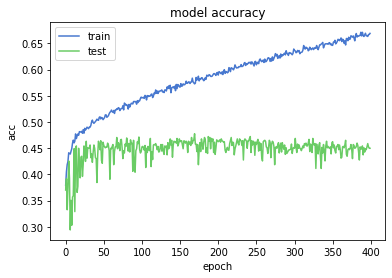

In [44]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
#save model
model_name = 'IEMOCAP_male_9_5feMALE_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\ioann\saved_models\IEMOCAP_male_9_5feMALE_Model.h5 


In [46]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [47]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/Users/ioann/saved_models/IEMOCAP_male_9_5feMALE_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 44.98%


In [48]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

1116/1116 [==============================] - ETA:  - ETA:  - 0s 140us/step


In [49]:
preds1=preds.argmax(axis=1)
preds1

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [50]:
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))

In [51]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,oth
1,n
2,oth
3,n
4,n
5,p
6,oth
7,p
8,n
9,oth


In [52]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [53]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,n
1,n
2,n
3,n
4,n
5,n
6,n
7,n
8,n
9,n


In [54]:
finaldf = actualdf.join(preddf)
finaldf

,actualvalues,predictedvalues
0,n,oth
1,n,n
2,n,oth
3,n,n
4,n,n
5,n,p
6,n,oth
7,n,p
8,n,n
9,n,oth


In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix(actualvalues, predictions)


array([[350,  89,  62],
       [179,  93,  35],
       [144, 105,  59]], dtype=int64)

In [56]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
n,501
oth,307
p,308


In [57]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
n,673
oth,287
p,156


In [58]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [59]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

44.982078853046595

In [60]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[350,  89,  62],
       [179,  93,  35],
       [144, 105,  59]], dtype=int64)

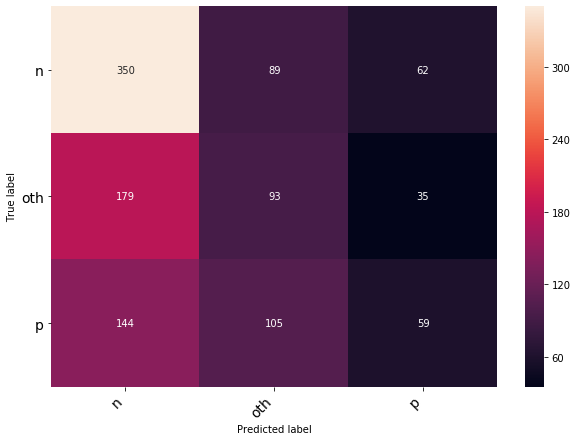

In [65]:
class_names = ["n", "oth", "p"]


print_confusion_matrix( c , class_names)

In [63]:
import seaborn as sns;

In [68]:
def lstm_model(optimizer='Adadelta'):
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(100, 34)))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [70]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 1, 256)            1536      
_________________________________________________________________
activation_6 (Activation)    (None, 1, 256)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 128)            163968    
_________________________________________________________________
activation_7 (Activation)    (None, 1, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1, 128)           

In [71]:
hist = model.fit(x_traincnn, y_train, 
                 batch_size=100, nb_epoch=400, verbose=1, shuffle = True, 
                 validation_split=0.2)

C:\Users\ioann\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 7136 samples, validate on 1785 samples
Epoch 1/400


ValueError: setting an array element with a sequence.